# Проект  по анализу сервиса аренды самокатов GoFast 
Добрый день!
В данном проекте я выстыпаю аналитиком GoFast. Цель - увеличить доходы компании. 

Можно выделить следующие задачи:
- ознакомление с данными;
- предобработка;
- визуализация данных;
- объединение информации;
- подсчёт выручки;
- проверка гипотез;
- прогнозирование моделей.

В данном проекте работа ведётся с помощью трёх разных датасетов, одна из задач - объединить их. Также стоит выделить, что основным различием является наличие подписки у пользователей. 

P.S. под большинством строк кода я буду оставлять свои комментарии и делать небольшие выводы в таком формате: **<font color="green">Комментарий студента:<font>** 

In [1]:
!pip install missingno

In [2]:
import pandas as pd
from scipy import stats as st
from math import factorial, sqrt
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
pd.set_option('display.float_format', '{:.2f}'.format)

**<font color="green">Комментарий студента:<font>** Установка и импортирование библиотек

### Загрузка данных

In [3]:
datauser = pd.read_csv('/datasets/users_go.csv')
datarides = pd.read_csv('/datasets/rides_go.csv')
datasub = pd.read_csv('/datasets/subscriptions_go.csv')
display(datauser.head(5))
display(datarides.head(5))
display(datasub)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**<font color="green">Комментарий студента:<font>** Загрузка данных через pandas и первое ознакомление с ними

In [4]:
datauser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


datasub.info()

In [5]:
datarides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
datasub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<div class="alert alert-info"> <b>Комментарий студента №2:</b> Более подробное ознакомление с данными. 
    В проекте есть информация о 1565 пользователях(имя, возраст и город), которые сделали более 18 000 поездок, расстояние и длительность этих поездок. А также наличие подписки у пользователей.
    
В датафреймах `name`, `city`, `subscription_type`, `date` представлены не в числовом формате, а в формате object, значения в `distance` и `duration` - числа с плавающей точкой, для всех остальных данных характерно int64(целые числа)
    
P.S. Обычно пропущенные значения я всегда рассматриваю в пункте преобработки данных, но если логически выполнять этот пункт здесь, то ок.

### Предобработка данных

In [7]:
datarides['date'] = pd.to_datetime(datarides['date'], format= '%Y-%m-%d')
datarides['month'] = datarides['date'].dt.month
print(datarides.isna().sum())
print(datauser.isna().sum())
print(datasub.isna().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [8]:
datarides['date'].describe(datetime_is_numeric=True)

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Проверяем столбец `date`. Все значения приходятся на 2021 год.

In [9]:
print(datarides.duplicated().sum())
print(datauser.duplicated().sum())
print(datasub.duplicated().sum())
datauser = datauser.drop_duplicates()

0
31
0


**<font color="green">Комментарий студента:<font>** В данной части мы обрабатываем все три датафрейма. В datarides мы переводим столбец `date` к типу даты в pandas, далее для каждой поездки мы создаем столбец с номером месяца. 
 
Проверяем на пропуски и на явные дубликаты.

### Исследовательский анализ данных

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


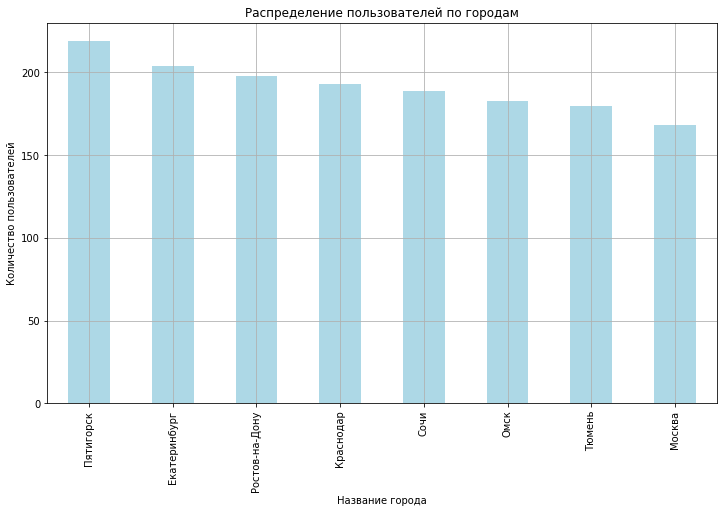

In [10]:
print(datauser['city'].value_counts())
datauser["city"].value_counts().plot.bar(title='Распределение пользователей по городам',\
figsize=(12, 7), grid=True, color = "lightblue", xlabel='Название города', ylabel='Количество пользователей');

**<font color="green">Комментарий студента:<font>** Визуализируем данные о городах, в которых компания ведёт свою деятельность и которые есть в датасете. Самый популярный город - Пятигорск, наименьшее количество пользователей в Москве, скорее всего, в Москве наибольшая конкуренция среди всех городов. Разница между двумя городами - 51 пользователь.

free     835
ultra    699
Name: subscription_type, dtype: int64


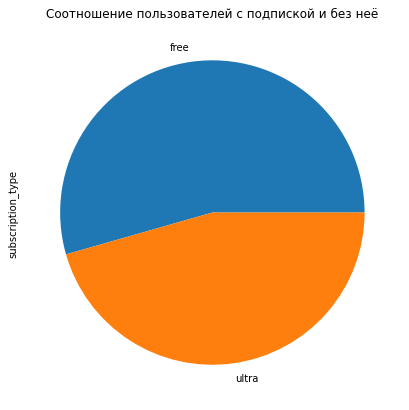

In [11]:
print(datauser["subscription_type"].value_counts())
datauser["subscription_type"].value_counts().plot.pie(title='Соотношение пользователей с подпиской и без неё',figsize=(12, 7));

In [12]:
a = 699
b = 835
c = (a + b)
print('Количество пользователей с подпиской составляет:',round(a/c*100, 2),'%')
print('Количество пользователей без подписки составляет:',round(b/c*100, 2),'%')

Количество пользователей с подпиской составляет: 45.57 %
Количество пользователей без подписки составляет: 54.43 %


**<font color="green">Комментарий студента:<font>** Информация о пользователях с подпиской и без. Клиентов с подпиской меньше порядка на 19%.

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

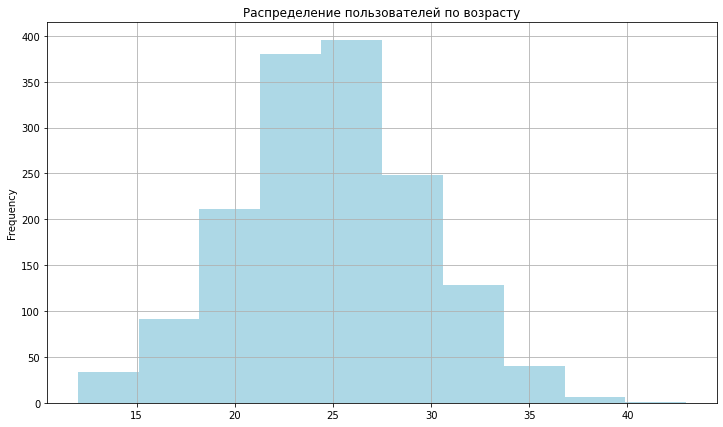

In [13]:
datauser['age'].plot(kind='hist', bins=10,title='Распределение пользователей по возрасту',\
figsize=(12, 7), grid=True, color = "lightblue", xlabel='Возраст пользователя', ylabel='Количество пользователей');
datauser['age'].value_counts()

**<font color="green">Комментарий студента:<font>** Рассмотрим информацию о возрасте пользователей. Средний возраст - 25 лет. Наибольший - 43 года. Также есть группа подростков-детей, которым меньше 16 лет.

count   18068.00
mean     3070.66
std      1116.83
min         0.86
25%      2543.23
50%      3133.61
75%      3776.22
max      7211.01
Name: distance, dtype: float64

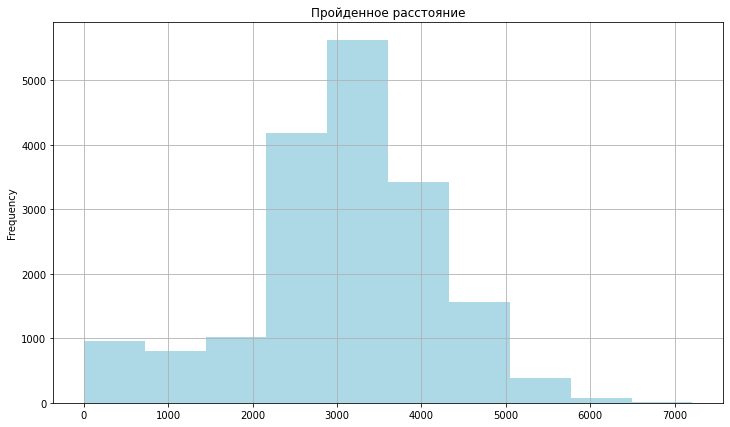

In [14]:
datarides['distance'].plot(kind='hist', bins=10,title='Пройденное расстояние',\
figsize=(12, 7), grid=True, color = "lightblue");
datarides['distance'].describe()

<AxesSubplot:>

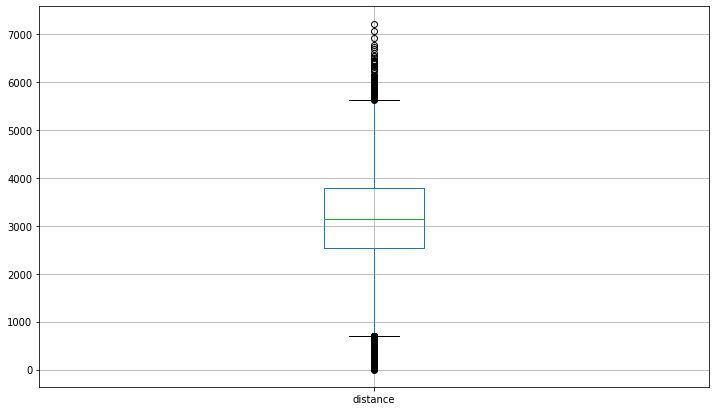

In [15]:
datarides.boxplot('distance', figsize=(12, 7))

In [16]:
datarides.query('distance < 10')

,user_id,distance,duration,date,month
7841,796,7.10,10.03,2021-11-26,11
8658,861,6.78,6.02,2021-07-21,7
9541,925,2.57,3.01,2021-10-19,10
11555,1069,0.86,10.00,2021-01-31,1
13690,1223,4.33,4.01,2021-05-22,5


**<font color="green">Комментарий студента:<font>** Здесь стоит обратить внимание на возможные аномальные значения. Всё что выходит за пределы третьего квартиля + 1.5 межквартильного размаха - нормальное явление, так как максимальное расстояние в 7км не является чем-то невозможным. 
    
То что меньше 1 квартиля + 1.5 межквартильного размаха тоже не является аномальным значением, так как в датафрейме нет нулевых значений, а значит с ними стоит продолжать работу.
    
Наибольшее частое расстояние - 3 км.

count   18068.00
mean       17.81
std         6.09
min         0.50
25%        13.60
50%        17.68
75%        21.72
max        40.82
Name: duration, dtype: float64

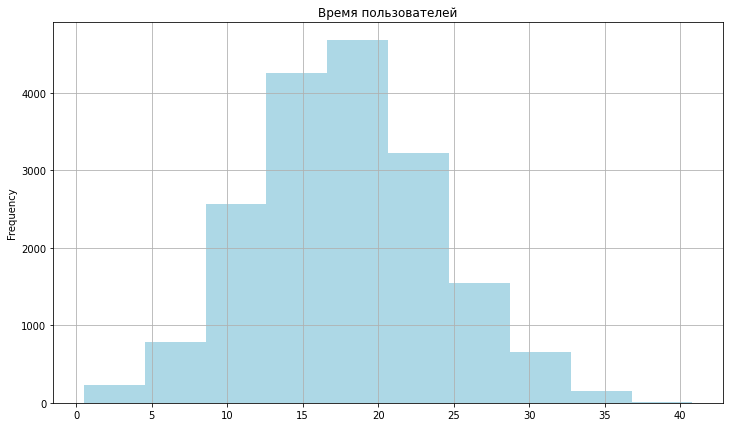

In [17]:
datarides['duration'].plot(kind='hist', bins=10,title='Время пользователей',\
figsize=(12, 7), grid=True, color = "lightblue");
datarides['duration'].describe()

<AxesSubplot:>

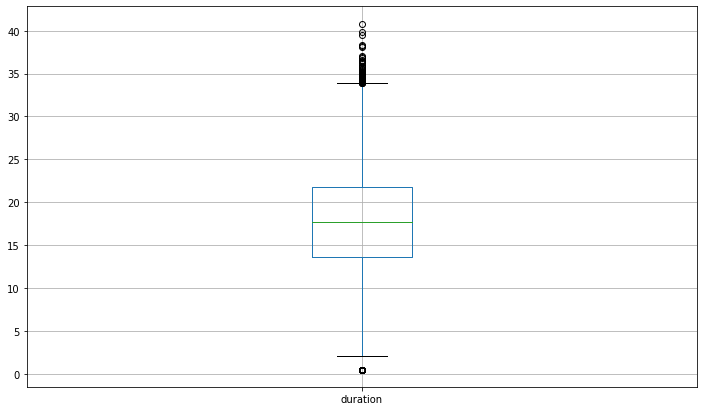

In [18]:
datarides.boxplot('duration', figsize=(12, 7))

In [19]:
datarides.query('duration > 40')

,user_id,distance,duration,date,month
4215,454,5137.33,40.82,2021-12-27,12


**<font color="green">Комментарий студента:<font>** Аналогичная проверка и для длительности поездок. Есть значения, которые выходят за пределы диаграммы размаха, но они не являются аномалиями.

Чаще всего самокат арендуют от 15 до 20 минут.
    
    
**В данном шаге** были визуализированы данные по основным разделам, а также проанализированны возможные аномалии.

### Объединение данных

In [20]:
dataqwe = datauser.merge(datarides, on='user_id')

In [21]:
dataqwe = dataqwe.merge(datasub, on='subscription_type')
dataqwe['duration'] = np.ceil(dataqwe['duration']) 
display(dataqwe)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.00,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.00,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.00,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.00,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.00,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,20.00,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,22.00,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,19.00,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,17.00,2021-11-27,11,8,50,0


In [22]:
dataqwe.info()
print()
print(dataqwe.isna().sum())
print()
print(dataqwe.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB

user_id              0
name            

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Размер датафрейма не изменился, пропуски также отсутствуют.

**<font color="green">Комментарий студента:<font>** На данном этапе соединяем все три таблицы в одну единую с помощью метода merge(), а также округляем значения в столбце `duration`.

In [23]:
datafree = dataqwe.query('subscription_type == "free"')
dataultra = dataqwe.query('subscription_type == "ultra"')

**<font color="green">Комментарий студента:<font>** Из уже основной таблицы создаём две отдельные, которые будут отличаться по наличию подписки у пользователей. Визуализируем их.

In [24]:
datafree['distance'].describe()

count   11568.00
mean     3045.50
std      1246.17
min         0.86
25%      2366.56
50%      3114.65
75%      3905.70
max      7211.01
Name: distance, dtype: float64

**<font color="green">Комментарий студента:<font>** Всего в данной таблице более 11 000 поездок пользователей, у которых нет подписки. Среднее значение не сильно отличается от общей таблицы, здесь среднее расстояние от 2 200 метров до 3 500 метров.

In [25]:
datafree['duration'].describe()

count   11568.00
mean       17.89
std         6.33
min         1.00
25%        13.00
50%        18.00
75%        22.00
max        35.00
Name: duration, dtype: float64

**<font color="green">Комментарий студента:<font>** Минимальное время поездки - одна минута, максимальная - 35.

In [26]:
dataultra['distance'].describe()

count   6500.00
mean    3115.45
std      836.90
min      244.21
25%     2785.44
50%     3148.64
75%     3560.57
max     5699.77
Name: distance, dtype: float64

**<font color="green">Комментарий студента:<font>** Для пользователей с подпиской среднее расстояние от 3 до 3.5км.

In [27]:
dataultra['duration'].describe()

count   6500.00
mean      19.04
std        5.58
min        4.00
25%       15.00
50%       19.00
75%       22.00
max       41.00
Name: duration, dtype: float64

**<font color="green">Комментарий студента:<font>** Среднее время поездки от 13 до 25 минут.

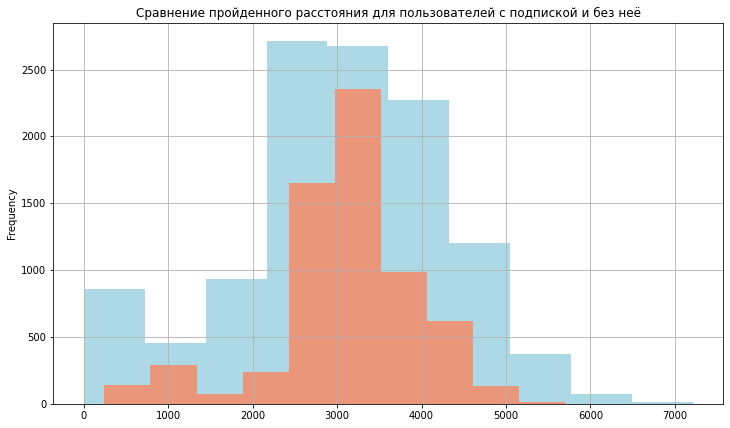

In [28]:
datafree['distance'].plot(kind='hist',bins=10,title='Сравнение пройденного расстояния для пользователей с подпиской и без неё',\
figsize=(12, 7), grid=True, color = "lightblue");
dataultra['distance'].plot(kind='hist', bins=10,\
figsize=(12, 7), grid=True, color = "darksalmon");

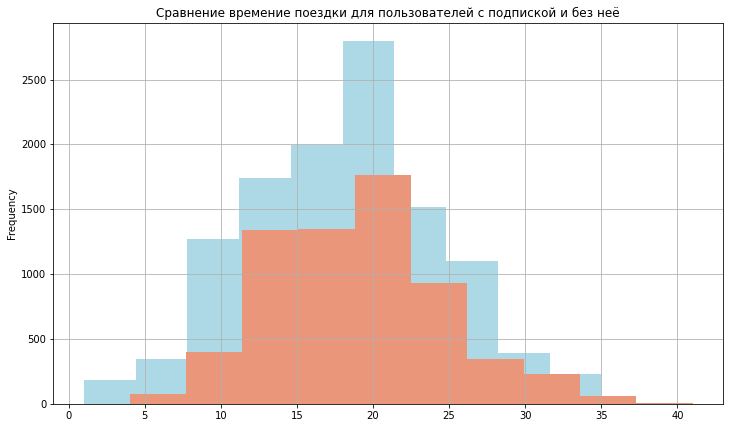

In [29]:
datafree['duration'].plot(kind='hist', bins=10,title='Сравнение времение поездки для пользователей с подпиской и без неё',\
figsize=(12, 7), grid=True, color = "lightblue");
dataultra['duration'].plot(kind='hist', bins=10,figsize=(12, 7), grid=True, color = "darksalmon");

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Сравнив два графика можно выделить общую тенденцию для пользователей с подпиской и без подписки. В обоих случаях можно выявить сходства, разница только в максимальном значении, которое достигают пользователи без подписки относительно клиентов с ней. Однако такую разницу стоит аргументировать количеством пользователей.

**В данном шаге** были объединены все три таблицы, а также созданы две новые с одним условием - наличие подписки. Также были представлены гистограммы для новых таблиц.

### Подсчёт выручки

In [30]:
data = dataqwe.pivot_table\
(index=['user_id', 'month'],\
values=['duration', 'distance', 'name', 'subscription_type', 'minute_price','start_ride_price', 'subscription_fee'],\
aggfunc=\
{'duration':'sum', 'distance': 'sum', 'name':'count', 'subscription_type' : min, 'minute_price': min, 'start_ride_price': min, 'subscription_fee': min})
data = data.rename(columns={'name': 'total_rides'})

In [31]:
data.isna().sum()

distance             0
duration             0
minute_price         0
total_rides          0
start_ride_price     0
subscription_fee     0
subscription_type    0
dtype: int64

In [32]:
def qwe(q):
    if q['subscription_type'] == 'ultra':
        return q['minute_price'] * q['duration'] + q['subscription_fee']
    elif q['subscription_type'] == 'free':
        return q['start_ride_price'] * q['total_rides'] + q['minute_price'] * q['duration'] + q['subscription_fee']

In [33]:
data['revenue'] = data.apply(qwe, axis=1)
data

distance  duration  minute_price  total_rides  \
user_id month                                                  
1       1       7027.51     42.00             6            2   
        4        754.16      7.00             6            1   
        8       6723.47     46.00             6            2   
        10      5809.91     32.00             6            2   
        11      7003.50     56.00             6            3   
...                 ...       ...           ...          ...   
1534    6       3409.47     26.00             8            2   
        8       7622.45     48.00             8            2   
        9       4928.17     23.00             8            1   
        11     13350.02     78.00             8            4   
        12      2371.71     16.00             8            1   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
1       1                     0               199             ultra   451.00  
        4                     0               199             ultra   241.00  
        8                     0               199             ultra   475.00  
        10                    0               199             ultra   391.00  
        11                    0               199             ultra   535.00  
...                         ...               ...               ...      ...  
1534    6                    50                 0              free   308.00  
        8                    50                 0              free   484.00  
        9                    50                 0              free   234.00  
        11                   50                 0              free   824.00  
        12                   50                 0              free   178.00  

[11331 rows x 8 columns]

**<font color="green">Комментарий студента:<font>** Здесь я создаю сводную таблицу по пользователям и месяцам, где считаю общее количество поездок, их расстояние и длительность поездок. Далее с помощью функции и метода apply() добавляю новый столбец с ежемесячной выручкой для каждого пользователя. Итоговая таблица представлена выше.
    
P.S. Скорее всего можно было обойтись и без функции, а именно:

**data['revenue'] = data['distance'] *...** Но могу быть неправ.

### Проверка гипотез

**<font color="green">Комментарий студента:<font>** Для всех тестов я выбрал значение уровня статистической значимости - 0.05. Сами тесты различаются в завимости от задания.

**6.1** Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

**H0** - среднее время поездки для пользователей с подпиской равна среднему времени поездки для пользователей без подписки.

**H1** - среднее время поездки для пользователей с подпиской больше, чем у пользователей без неё.

In [34]:
#6.1.
alpha = 0.05
results6_1 = st.ttest_ind(dataultra['duration'], datafree['duration'], equal_var=False, alternative='greater')
print('p-значение:', results6_1.pvalue)
if results6_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


<div class="alert alert-info"> <b>Комментарий студента №2:</b> Здесь с помощью уже созданных таблиц я сравниваю среднее двух генеральных совокупностей.

Итог - наличие подписки влияет на среднее время поездки, пользователи с подпиской ездят дольше. Компании стоит сделать упор на подписки, чтобы увеличить доход.

**6.2** Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

**H0** - Среднее расстояние пользователей в подпиской = 3130 метров.

**H1** - Среднее расстояние пользователей в подпиской больше 3130 метров.

In [35]:
#6.2
interested_value = 3130
alpha = 0.05
results = st.ttest_1samp(dataultra['distance'], interested_value, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**<font color="green">Комментарий студента:<font>** Таблицу с пользователями с подпиской сравнием с конкретным значением в 3130 метров.
    
Как итог не получилось отвергнуть нулевую гипотезу, пользователи с подпиской в среднем проезжают меньше данного значения.

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Компании GoFast стоит обратить внимание на наличие подписки у пользователей, в среднем клиенты с ежемесячной подпиской не подвергают самокат износу.

**6.3** Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

**H0** - Средняя ежемесячная выручка у пользователей с подпиской равна средней ежемесячной выручке у пользователей без неё.

**H1** - Средняя ежемесячная выручка у пользователей с подпиской больше чем у пользователей без неё.

In [36]:
#6.3
datanew1 = data.query('subscription_type == "free"')
datanew2 = data.query('subscription_type == "ultra"')

In [37]:
alpha = 0.05
results1 = st.ttest_ind(datanew2['revenue'], datanew1['revenue'], equal_var=False, alternative='greater')
print('p-значение:', results1.pvalue)
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


<div class="alert alert-info"> <b>Комментарий студента №2:</b> На первом шаге создаем два новых датафрейма, так как в старых нет информации о выручки
    
Дальше с помощью теста о средних двух генеральных совокупностей проверяем нулевую и альтернативную гипотезу.
    

Итог - люди с подпиской в среднем тратят больше денег на поездки в месяц, чем пользователи без неё.

**6.4. Для данной гипотезы подойдёт метод scipy.stats.ttest_rel(). Так как речь идёт о парной выборки до и после изменения.**

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Односторонняя. 

H0 - количество обращений "до" и "после" одинакова

H1 - количество обращений "после" < "до"

<div class="alert alert-info"> <b>Обновленный вывод 6 шага:</b> Две нулевые гипотезы были отвергнуты в пользу альтернативных, одну отвергнуть не получилось. Сервису GoFast стоит акцентировать внимание на наличие подписки у пользователей, ведь с точки зрения дохода они являются наиболее выгодными.
  
На данном этапе были использованы различные тесты, такие как: st.ttest_ind() и st.ttest_1samp().

### Распределения

7.1. Вероятность равна 10%, стартовое значение количества попыток - 1000, интересующее значение - 100.

In [38]:
p = 0.1
n = 1000
k = 100
prob = st.binom.cdf(k,n,p)
prob

0.5265990812951653

**<font color="green">Комментарий студента:<font>** При 1000 попытках вероятность равна чуть более 50%. С помощью цикла while найдём нужное количество попыток:

In [39]:
while prob > 0.05:
    n += 1
    prob = st.binom.cdf(k,n,p)
print(n)

1172


**<font color="green">Комментарий студента:<font>** 1172 оптимальное количество попыток, чтобы получить минимальное возможное значение в 100 подписок.

7.2. Количество уведомлений один миллион, интересующее значение почти 400 000, вероятность на основе прошлых исследований - 40%. 

In [40]:
n = 1000000 
p = 0.4
mu =n*p
sigma = sqrt(n * p * (1-p))
distr = st.norm(mu, sigma)
result = distr.cdf(399500)
print(result)

0.15371708296369768


<div class="alert alert-info"> <b>Комментарий студента №2:</b> При миллионе уведомлений, вероятность открыть не более 399500 рассылок равна 15%

**<font color="green">Комментарий студента:<font>** Итог данного этапа:
    
Были спрогнозированы два возможных случая, которые интересуют компанию.

К сожалению, не знаю как построить графики, помогите...

### Обновленный общий вывод

В проекте были поставлены цели и задачи. Главной целью является увеличение бизнес-показателей компании.

Задачи были разбиты на 7 шагов, от загрузки данных до проверки гипотез с прогнозированием случаев. 

В первом пункте была изучена первичная информация проекта

Во втором пункте были обработаны данные и преобразован тип данных для работы с датой в pandas

В третьем пункте были визуализорованы данные таблиц, также информация была изучена на возможные аномалии.

В четвертом и пятом пункте были объединены таблицы по различным условиям и добавлена ежемесячная выручка для каждого пользователя. Основные инструменты метод merge(), query(), функция и метод apply(). 

В шестом пункте были проверены гипотезы, на их основе компания может улучшить свою выручку и сделать правильные выводы для дальнейшего развития. 

В седьмом пункте были спрогнозированы случаи, когда компания с помощью рассылок может увеличить свои показатели по количеству клиентов с подпиской.

<div class="alert alert-info"> <b>Комментарий студента №2:</b> Да. Пользователи с подпиской приносят больше выгоды для сервиса, чем пользователи без неё. Например:

- Пользователи с подпиской тратят больше времени на поездки, что означает бОльшую выгоду для компании;

- В среднем пользователи с подпиской проезжают менее 3130 метров, что меньше сказывается на износе самоката;
  
- Учитывая, что подписка стоит 199 рублей в месяц, в среднем пользователи с подпиской приносят больше дохода в месяц, чем пользователи без неё.